In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
articles_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles.csv")
authors_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors.csv")
author_article_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles_authors.csv")
affiliations_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/affiliations.csv")
author_institution_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors_affiliations.csv")

In [ ]:
author_links = author_article_links_df.merge(
    author_institution_links_df, on='author_id', how='left'
)

# 2. Merge with institution data
author_links = author_links.merge(
    affiliations_df, left_on='affiliation_id', right_on='identifier', how='left', suffixes=('', '_inst')
)

# 3. Merge with article data to bring in publication details
full_df = author_links.merge(
    articles_df, left_on='article_id', right_on='identifier', how='left', suffixes=('', '_article')
)

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date']).dt.year

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date'], errors='coerce').dt.year


# 5. Group by institution and year
inst_yearly_counts = (
    full_df.groupby(['affiliation_name', 'pub_year'])
    .agg(num_publications=('article_id', 'nunique'))
    .reset_index()
)

# Only keep institutions with at least 2 years of data
filtered_inst_yearly_counts = (
    inst_yearly_counts.groupby("affiliation_name")
    .filter(lambda x: x['pub_year'].nunique() >= 2)
)

In [ ]:
# prompt: show me how many publications i have in the last year of data for a target institution

target_institution = 'Universidad Central del Ecuador'  # Replace with the actual institution name

# Filter the DataFrame for the target institution
target_inst_data = filtered_inst_yearly_counts[
    filtered_inst_yearly_counts['affiliation_name'] == target_institution
]

if not target_inst_data.empty:
    # Find the last available year for the target institution
    last_year = target_inst_data['pub_year'].max()

    # Filter the data for the last year
    last_year_data = target_inst_data[target_inst_data['pub_year'] == last_year]

    # Get the number of publications in the last year
    if not last_year_data.empty:
        publications_last_year = last_year_data['num_publications'].iloc[0]
        print(f"The target institution '{target_institution}' had {publications_last_year} publications in {last_year}.")
    else:
        print(f"No publication data found for the last year ({last_year}) for the institution '{target_institution}'.")
else:
    print(f"No data found for the institution '{target_institution}'. Please check the institution name.")

The target institution 'Universidad Central del Ecuador' had 195 publications in 2022.


In [ ]:
target_institution = 'Universidad Central del Ecuador'

📊 Evaluation for Universidad Central del Ecuador
Model Used: Linear Regression
Actual 2022: 195
Predicted 2022: 241.15
MAE: 46.15 | RMSE: 46.15

🔮 Forecast 2025–2035 using Linear Regression:
2025: 263.91
2026: 273.28
2027: 282.64
2028: 292.01
2029: 301.38
2030: 310.75
2031: 320.12
2032: 329.49
2033: 338.85
2034: 348.22
2035: 357.59


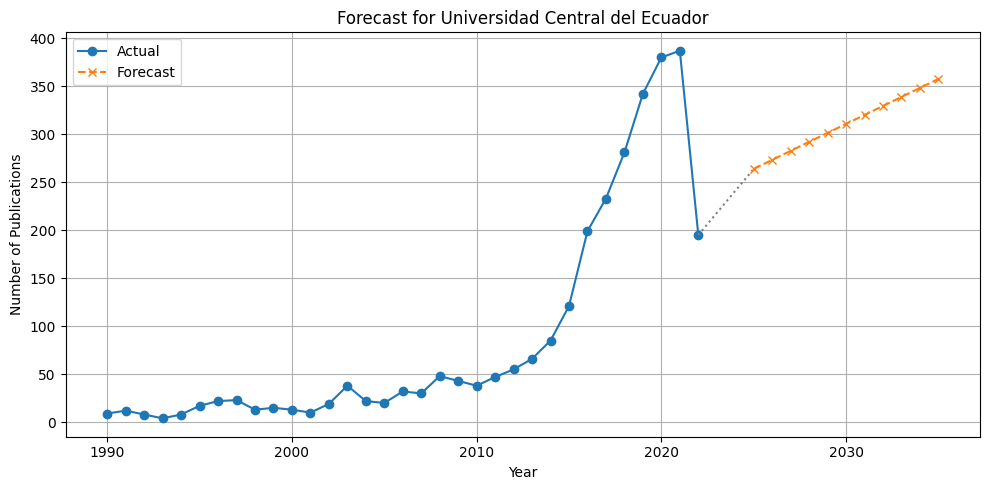

In [ ]:
group = inst_yearly_counts[
    (inst_yearly_counts['affiliation_name'] == target_institution) &
    (inst_yearly_counts['pub_year'] >= 1990)
].sort_values("pub_year")

# 2. Check if we have enough data
num_years = group['pub_year'].nunique()
if num_years < 2:
    print("❌ Not enough data to evaluate.")
else:
    # 3. Separate evaluation and training
    last_year = group['pub_year'].max()
    train_eval = group[group['pub_year'] < last_year]
    eval_row = group[group['pub_year'] == last_year]

    if train_eval.empty or eval_row.empty:
        print("⚠️ Not enough data for training or evaluation.")
    else:
        X_train_eval = train_eval['pub_year'].values.reshape(-1, 1)
        y_train_eval = train_eval['num_publications'].values
        actual_eval = eval_row['num_publications'].values[0]

        # Choose model based on data size
        if len(X_train_eval) >= 5:
            model = LinearRegression().fit(X_train_eval, y_train_eval)
            pred_eval = model.predict(np.array([[last_year]]))[0]
            model_type = 'Linear Regression'
        elif 3 <= len(X_train_eval) < 5:
            poly = PolynomialFeatures(degree=2)
            model = LinearRegression().fit(poly.fit_transform(X_train_eval), y_train_eval)
            pred_eval = model.predict(poly.transform(np.array([[last_year]])))[0]
            model_type = 'Polynomial Regression'
        else:
            pred_eval = np.mean(y_train_eval)
            model_type = 'Mean Predictor'

        mae = mean_absolute_error([actual_eval], [pred_eval])
        mse = mean_squared_error([actual_eval], [pred_eval])
        rmse = np.sqrt(mse)

        print(f"📊 Evaluation for {target_institution}")
        print(f"Model Used: {model_type}")
        print(f"Actual {last_year}: {actual_eval}")
        print(f"Predicted {last_year}: {round(pred_eval, 2)}")
        print(f"MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # 4. Forecast from 2025 to 2035
    X_forecast = group['pub_year'].values.reshape(-1, 1)
    y_forecast = group['num_publications'].values
    future_years = np.arange(2025, 2036).reshape(-1, 1)

    if len(X_forecast) >= 5:
        model = LinearRegression().fit(X_forecast, y_forecast)
        future_preds = model.predict(future_years)
        forecast_model = 'Linear Regression'
    elif 3 <= len(X_forecast) < 5:
        poly = PolynomialFeatures(degree=2)
        model = LinearRegression().fit(poly.fit_transform(X_forecast), y_forecast)
        future_preds = model.predict(poly.transform(future_years))
        forecast_model = 'Polynomial Regression'
    else:
        future_preds = [np.mean(y_forecast)] * len(future_years)
        forecast_model = 'Mean Predictor'

    print(f"\n🔮 Forecast 2025–2035 using {forecast_model}:")
    for year, pred in zip(future_years.flatten(), future_preds):
        print(f"{year}: {round(pred, 2)}")

    # 5. Plot actual + evaluation + forecast
    plt.figure(figsize=(10, 5))
    plt.plot(group['pub_year'], group['num_publications'], marker='o', label='Actual')

    # Dotted line connecting last actual point to forecast
    plt.plot(
        [last_year, future_years[0][0]],
        [group[group['pub_year'] == last_year]['num_publications'].values[0], future_preds[0]],
        linestyle='dotted', color='gray'
    )
    plt.plot(future_years.flatten(), future_preds, linestyle='--', marker='x', label='Forecast')
    plt.title(f"Forecast for {target_institution}")
    plt.xlabel("Year")
    plt.ylabel("Number of Publications")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
